# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
import torch, torchvision
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

In [10]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

./tiny-imagenet-200.zip


In [89]:
means = (0.4914, 0.4822, 0.4465)
stds = (0.2023, 0.1994, 0.2010)
transform_train = transforms.Compose([
   transforms.RandomCrop(48),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize(means, stds),
])
transform_test = transforms.Compose([
    transforms.CenterCrop(48),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [90]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform_train)
test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=transform_test)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])

In [91]:
val_dataset.dataset.transform = transform_train
train_dataset.dataset.transform, val_dataset.dataset.transform

(Compose(
     RandomCrop(size=(48, 48), padding=0)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
 ), Compose(
     RandomCrop(size=(48, 48), padding=0)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
 ))

In [92]:
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [17]:
# feel free to copypaste code from seminar03 as a basic template for training

In [19]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [47]:
model = nn.Sequential()
model.add_module('conv_1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1))
model.add_module('batch_norm_1', nn.BatchNorm2d(num_features=64))
model.add_module('relu_conv_1', nn.ReLU())
model.add_module('pool_1', nn.MaxPool2d(kernel_size=2))

model.add_module('conv_2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('batch_norm_2', nn.BatchNorm2d(num_features=128))
model.add_module('relu_conv_2', nn.ReLU())
model.add_module('pool_2', nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('batch_norm_3', nn.BatchNorm2d(num_features=256))
model.add_module('relu_conv_3', nn.ReLU())
model.add_module('pool_3', nn.MaxPool2d(kernel_size=2))

model.add_module('flatten', Flatten())
model.add_module('drop_0', nn.Dropout(p=0.2))
model.add_module('dense_1', nn.Linear(in_features=9216, out_features=1024))
model.add_module('relu_dense_1', nn.ReLU())
model.add_module('drop_1', nn.Dropout(p=0.2))
model.add_module('logits', nn.Linear(in_features=1024, out_features=200))

In [48]:
with torch.cuda.device(1):
    model_gpu = model.cuda()

In [49]:
train_loss = []
val_acc = []
opt = torch.optim.Adam(model_gpu.parameters(), lr=0.001)

In [50]:
from tqdm import tqdm
from IPython.display import clear_output


100%|██████████| 100/100 [34:10<00:00, 20.48s/it]


 mean training loss: 1.934136
 validation accuracy: 38.6914


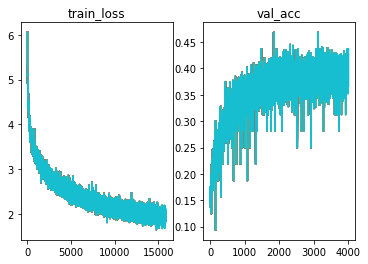

In [54]:
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    model_gpu.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_loader:
        # train on batch
        with torch.cuda.device(1):
            X = X_batch.cuda()
            y = y_batch.cuda()
            logits = model_gpu(X)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.detach().cpu().numpy())

    model_gpu.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        with torch.no_grad():
            with torch.cuda.device(1):
                X = X_batch.cuda()
                logits = model_gpu(X)
            y_pred = torch.max(logits, dim=1)[1]
            val_acc.append(np.mean((y_batch == y_pred.cpu()).numpy()))
    
    
    # Then we print the results for this epoch:
    print(" mean training loss: {:.6f}".format(np.mean(train_loss[-len(train_dataset) // BATCH_SIZE :])))
    print(" validation accuracy: {:.4f}".format(np.mean(val_acc[-len(val_dataset) // BATCH_SIZE :]) * 100))
    clear_output(True)
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.title('train_loss')
    plt.subplot(1, 2, 2)
    plt.plot(val_acc)
    plt.title('val_acc')
    

 mean training loss: 1.897955
 validation accuracy: 38.9062


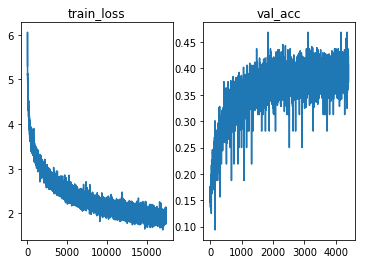


100%|██████████| 5/5 [01:44<00:00, 20.81s/it]


In [78]:
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    model_gpu.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_loader:
        # train on batch
        with torch.cuda.device(1):
            X = X_batch.cuda()
            y = y_batch.cuda()
            logits = model_gpu(X)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.detach().cpu().numpy())

    model_gpu.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        with torch.no_grad():
            with torch.cuda.device(1):
                X = X_batch.cuda()
                logits = model_gpu(X)
            y_pred = torch.max(logits, dim=1)[1]
            val_acc.append(np.mean((y_batch == y_pred.cpu()).numpy()))
    
    
    # Then we print the results for this epoch:
    clear_output(True)
    print(" mean training loss: {:.6f}".format(np.mean(train_loss[-len(train_dataset) // BATCH_SIZE :])))
    print(" validation accuracy: {:.4f}".format(np.mean(val_acc[-len(val_dataset) // BATCH_SIZE :]) * 100))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.title('train_loss')
    plt.subplot(1, 2, 2)
    plt.plot(val_acc)
    plt.title('val_acc')
    plt.show()

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [83]:
import pandas as pd

In [84]:
data = pd.read_csv('tiny-imagenet-200/val/val_annotations.txt', sep='\t', names=['name', 'categ', 'f1', 'f2', 'f3', 'f4'])
data.head()

,name,categ,f1,f2,f3,f4
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [86]:
import os
dst_path = 'tiny-imagenet-200/true_val'
os.mkdir(dst_path)
for categ in data.categ.unique():
    os.mkdir(os.path.join(dst_path, categ))

In [88]:
import shutil
for i, row in data.iterrows():
    shutil.copyfile('tiny-imagenet-200/val/images/{}'.format(row[0]), os.path.join(dst_path, row[1], row[0]))

In [93]:
test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/true_val', transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [97]:
correct = 0.0
model_gpu.train(False)
for X_batch, y_batch in test_loader:
    with torch.no_grad():
        with torch.cuda.device(1):
            X = X_batch.cuda()
            logits = model_gpu(X)
        y_pred = torch.max(logits, dim=1)[1]
        correct += np.sum((y_batch == y_pred.cpu()).numpy())

In [98]:
test_accuracy = correct / len(test_dataset)

In [99]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		40.65 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `Филипп`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
наберет 40% точности с минимальной болью. Я подумал, что кропать до 32 слишком жестко и решил остановиться на кропе до 48. Также в семинаре из 1 слоя сверток ничего хорошего не вышло, так что я решил, что где не сможет 1 там справятся 3. Так же 128 фильтров сразу многовато, так что будем постепенно повышать до 256. Батчнормы, (куда ж без них), ну и 1 скрытый слой с дропаутом в конце.

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
я получил качество на тесте в 0.7%. Как же так подумал я и начал искать багу. Удивительно, но я ничего не нашел. Через полдня я узнал, что валидационная часть не разбита на папки как обучающая. У меня пригорело, я разбил и получил 40.65%

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


с валидацией как-то не очень получилось(